# 하이퍼파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [57]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 주성분 분석 패키지
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

In [58]:
origin = my_read_excel("https://data.hossam.kr/mldata/iris.xlsx", info=False)


상위 5개 행
+----+----------------+---------------+----------------+---------------+-----------+
|    |   Sepal.Length |   Sepal.Width |   Petal.Length |   Petal.Width | Species   |
|----+----------------+---------------+----------------+---------------+-----------|
|  0 |            5.1 |           3.5 |            1.4 |           0.2 | setosa    |
|  1 |            4.9 |             3 |            1.4 |           0.2 | setosa    |
|  2 |            4.7 |           3.2 |            1.3 |           0.2 | setosa    |
|  3 |            4.6 |           3.1 |            1.5 |           0.2 | setosa    |
|  4 |              5 |           3.6 |            1.4 |           0.2 | setosa    |
+----+----------------+---------------+----------------+---------------+-----------+


## #02. 데이터 전처리

1. 종속변수 제거
2. 스케일링

In [59]:
x = origin.drop("Species", axis=1)
df = my_standard_scaler(x)
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


## #03. 하이퍼파라미터 튜닝을 통한 차원 축소

### [1] RandomizedSearchCV

In [60]:
estimator = PCA(random_state=0)
params = {
    # 2~4 사이를 추천
    "n_components": [0.95, 2, 3, 'mle'],
    "svd_solver": ["auto", "full", "arpack"],
    "tol": [0.0, 0.1, 0.5, 1.0],
}

model = RandomizedSearchCV(estimator, params, n_iter=10, cv=5, random_state=0)
model.fit(df)

print(model.best_params_)
print(model.best_score_)

{'tol': 0.0, 'svd_solver': 'arpack', 'n_components': 3}
-3.9367123415295806


### [2] 최적의 PCA 모델을 활용하여 차원축소 결과 생성

In [61]:
pca = model.best_estimator_.transform(df)
pca_df = DataFrame(pca, columns=model.best_estimator_.get_feature_names_out())
pca_df['target'] = origin['Species']
pca_df

,pca0,pca1,pca2,target
0,-2.264703,0.480027,-0.127706,setosa
1,-2.080961,-0.674134,-0.234609,setosa
2,-2.364229,-0.341908,0.044201,setosa
3,-2.299384,-0.597395,0.091290,setosa
4,-2.389842,0.646835,0.015738,setosa
...,...,...,...,...
145,1.870503,0.386966,0.256274,virginica
146,1.564580,-0.896687,-0.026371,virginica
147,1.521170,0.269069,0.180178,virginica
148,1.372788,1.011254,0.933395,virginica


## #04. 차원 축소 결과 해석

### [1] Biplot 시각화

Biplot은 PCA분석에서 찾은 주성분과 원데이터 변수간의 상관 관계를 보여주는 그래프

1. 각 PC축에 가깝게 평행을 이루는 변수가 해당 PC에 영향을 가장 많이 주는 변수.
2. 각 빨간선의 길이는 원변수의 분산을 표현, 길이가 길수록 분산이 길다.
3. 각 빨간선이 가까울수록 서로 상관관계가 있다. (반대로 서로 거리가 멀수록 상관관계가 적다.)

#### (1) 함수 정의

> 출처: https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/

In [62]:
def biplot(score, coeff, pcax, pcay, labels=None):
    pca1 = pcax - 1
    pca2 = pcay - 1
    xs = score[:, pca1]
    ys = score[:, pca2]
    n = score.shape[1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, pca1], coeff[i, pca2], color="r", alpha=0.5)
        if labels is None:
            plt.text(
                coeff[i, pca1] * 1.15,
                coeff[i, pca2] * 1.15,
                "Var" + str(i + 1),
                color="g",
                ha="center",
                va="center",
            )
        else:
            plt.text(
                coeff[i, pca1] * 1.15,
                coeff[i, pca2] * 1.15,
                labels[i],
                color="g",
                ha="center",
                va="center",
            )
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

#### (2) 함수 호출

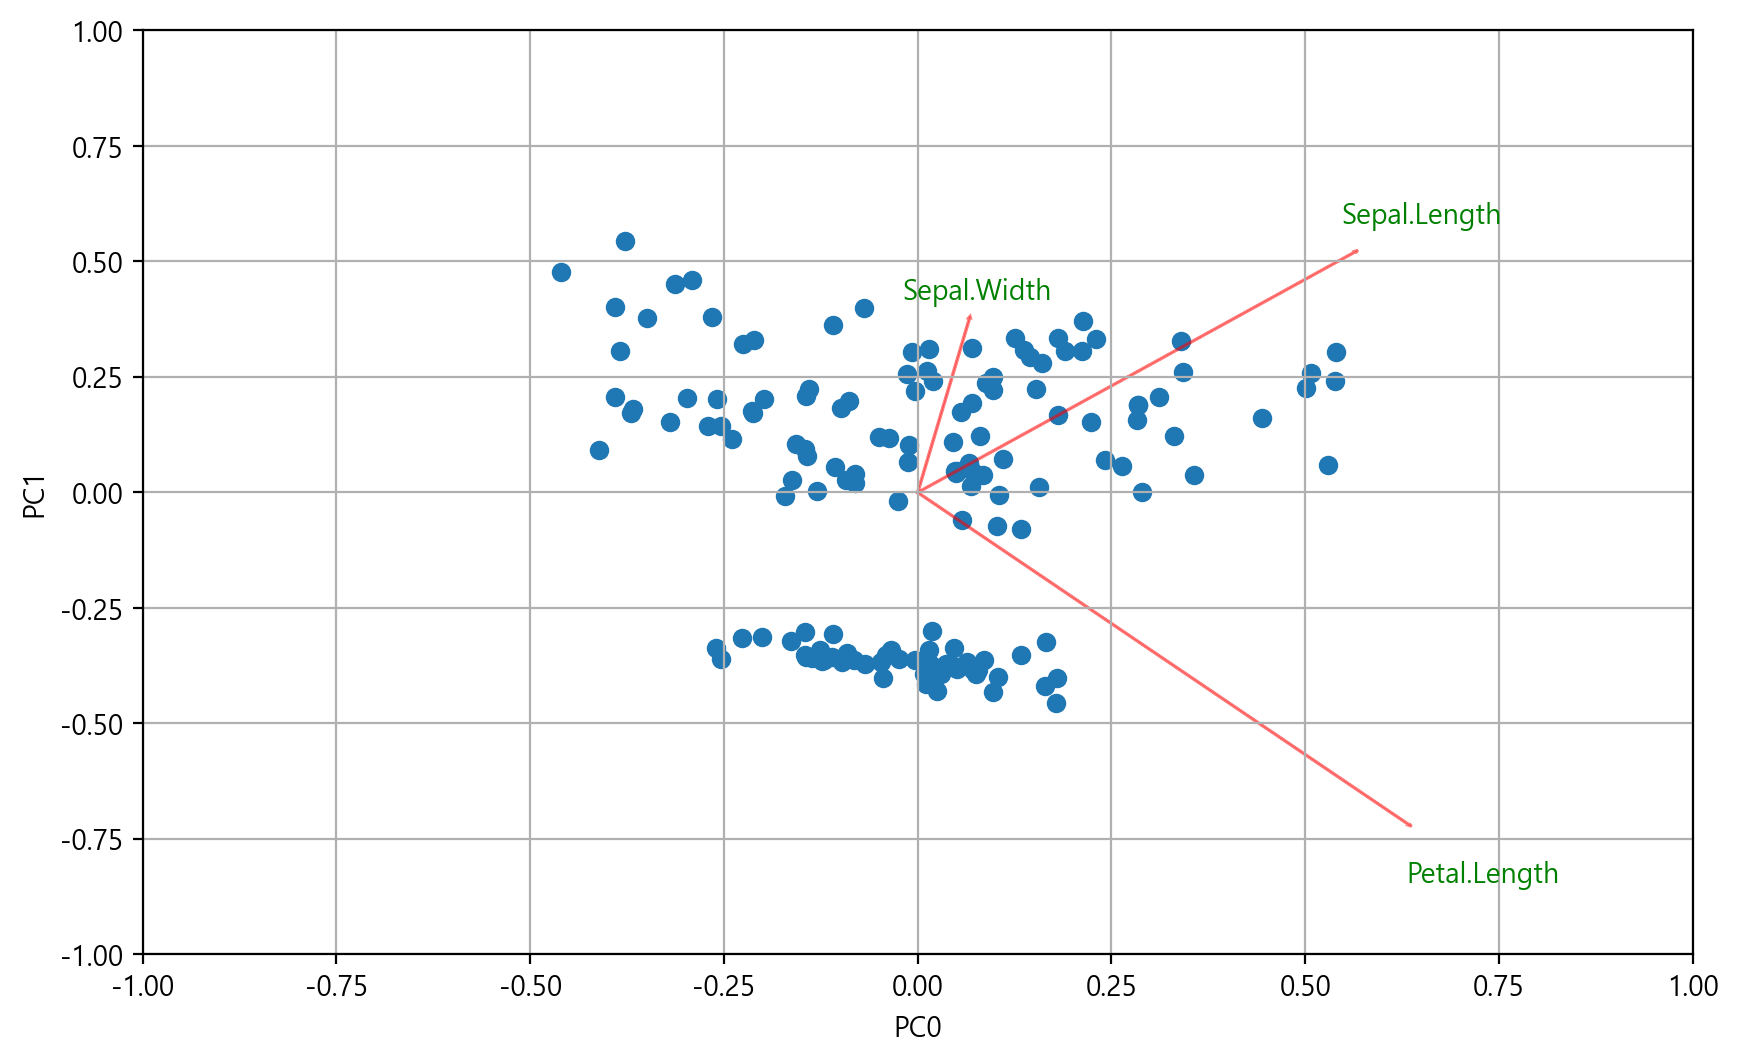

In [69]:
biplot(score=pca, coeff=model.best_estimator_.components_, pcax=0, pcay=1, labels=df.columns)

## #05. 주성분 분석 결과를 활용한 분류분석

In [64]:
target_df = my_labelling(pca_df, "target")
target_df

+------------+---------+
| target     |   label |
|------------+---------|
| setosa     |       0 |
| versicolor |       1 |
| virginica  |       2 |
+------------+---------+


,pca0,pca1,pca2,target
0,-2.264703,0.480027,-0.127706,0
1,-2.080961,-0.674134,-0.234609,0
2,-2.364229,-0.341908,0.044201,0
3,-2.299384,-0.597395,0.091290,0
4,-2.389842,0.646835,0.015738,0
...,...,...,...,...
145,1.870503,0.386966,0.256274,2
146,1.564580,-0.896687,-0.026371,2
147,1.521170,0.269069,0.180178,2
148,1.372788,1.011254,0.933395,2


In [65]:
x_train, x_test, y_train, y_test = my_train_test_split(target_df, yname='target')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((120, 3), (30, 3), (120,), (30,))

LogisticRegression({'n_jobs': -1, 'random_state': 1234}) {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000]}
KNeighborsClassifier({'n_jobs': -1}) {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
SVC({'n_jobs': -1, 'random_state': 1234}) {}
GaussianNB({}) {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
DecisionTreeClassifier({'random_state': 1234}) {'criterion': ['gini', 'entropy']}
SGDClassifier({'n_jobs': -1, 'random_state': 1234, 'early_stopping': True}) {'loss': ['hinge', 'log_loss', 'modified_huber'], 'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [1000, 2000, 3000, 4000, 5000], 'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'], 'eta0': [0.01, 0.1, 0.5]}
+------------------------+--------------------+---------------------+------------------+------------+------------+------------+
|                        |   정확도(Accuracy) 

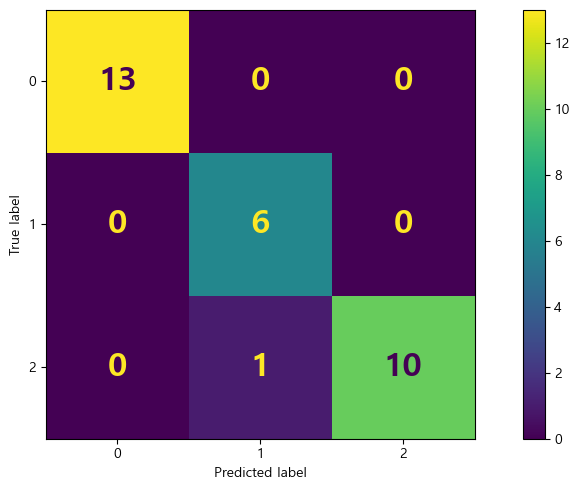


[학습곡선]


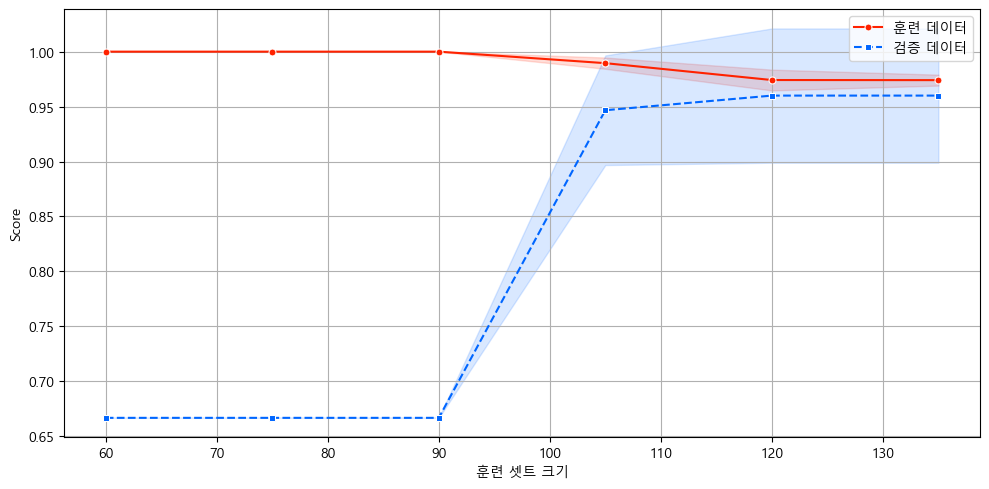

+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  0 | target     |       0 | pca0       | 1.00459 |
|  1 | target     |       0 | pca1       | 1.03485 |
|  2 | target     |       0 | pca2       | 1.03913 |
+----+------------+---------+------------+---------+
+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  0 | target     |       1 | pca0       | 1.00459 |
|  1 | target     |       1 | pca1       | 1.03485 |
|  2 | target     |       1 | pca2       | 1.03913 |
+----+------------+---------+------------+---------+
+----+------------+---------+------------+---------+
|    | 종속변수   |   CLASS | 독립변수   |     VIF |
|----+------------+---------+------------+---------|
|  0 | target     |       2 | pca0       | 1.00459 |
|  1 | target     |       2 | pca1       | 1.03485 |
|  2 | target    

{'SVC': SVC(n_jobs=-1, random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', random_state=1234),
 'GaussianNB': GaussianNB(),
 'LogisticRegression': LogisticRegression(C=10, max_iter=1000, n_jobs=1, random_state=1234),
 'KNeighborsClassifier': KNeighborsClassifier(metric='manhattan', n_jobs=-1),
 'SGDClassifier': SGDClassifier(alpha=0.01, early_stopping=True, eta0=0.1, loss='modified_huber',
               max_iter=5000, n_jobs=-1, penalty='elasticnet',
               random_state=1234),
 'best': SVC(n_jobs=-1, random_state=1234)}

In [66]:
my_classification(x_train, y_train, x_test, y_test)

> 이전 예제들에서 가장 좋은 성능을 보였던 경우는 SVM 모형에 대한 정확도 93.3%와, 정밀도 91.4%였다.
>
> 차원축소를 적용한 결과 SVC에서 정확도 96.7%와 정밀도 95.2%로 성능이 향상되었다.